## Crear index

In [1]:
import pyterrier as pt 
import os
import matplotlib.pyplot as plt

# Cargar dataset Vaswani (alias “npl”)
dataset = pt.datasets.get_dataset("vaswani")                  # 11 429 docs, 93 queries, 2 083 qrels

# Indexar con IterDictIndexer
index_path = "./vaswani_index"
if os.path.exists(index_path + "/data.properties"):
    tfidf = pt.BatchRetrieve(index_path + "/data.properties")
else:
    indexer = pt.index.IterDictIndexer(index_path)
    indexref = indexer.index(dataset.get_corpus_iter())
    tfidf = pt.BatchRetrieve(indexref, wmodel="TF_IDF")

/tmp/ipykernel_42136/4093397133.py:11: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  tfidf = pt.BatchRetrieve(index_path + "/data.properties")
Java started (triggered by Retriever.__init__) and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]


## Experimentos

In [2]:
topics = dataset.get_topics()#[:3]  # queries
qrels = dataset.get_qrels()#[:3] # juicios de relevancia
topics_rank = tfidf.transform(topics)   # ejecuta las consultas

topics[:3]

,qid,query
0,1,measurement of dielectric constant of liquids ...
1,2,mathematical analysis and design details of wa...
2,3,use of digital computers in the design of band...


### Global

In [3]:
# Experimento ámbito global: P@10, AP, nDCG@10 + gráfica R-P en 11 puntos
global_exp = pt.Experiment(
    [tfidf],    # tf-idf
    dataset.get_topics(), 
    dataset.get_qrels(),
    names=["TF-IDF"], 
    eval_metrics=["P_10", "map", "ndcg_cut_10"],
    perquery=False  # si es True, retorna los resultados de cada query; si es False, retorna el promedio global
)
print(global_exp)

     name      P_10       map  ndcg_cut_10
0  TF-IDF  0.358065  0.283614     0.434968


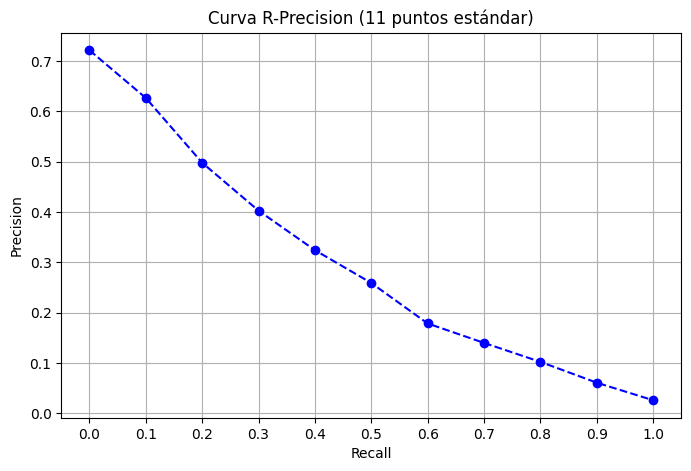

In [4]:
recall_points = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

pr_exp = pt.Experiment(
    [tfidf],
    topics,
    qrels,
    names=["TF-IDF"],
    eval_metrics=["iprec_at_recall_0.00", "iprec_at_recall_0.10", "iprec_at_recall_0.20", "iprec_at_recall_0.30", "iprec_at_recall_0.40", "iprec_at_recall_0.50", "iprec_at_recall_0.60", "iprec_at_recall_0.70", "iprec_at_recall_0.80", "iprec_at_recall_0.90", "iprec_at_recall_1.00"],
    perquery=False
)

precision_values = [
    pr_exp["iprec_at_recall_0.00"],
    pr_exp["iprec_at_recall_0.10"],
    pr_exp["iprec_at_recall_0.20"],
    pr_exp["iprec_at_recall_0.30"],
    pr_exp["iprec_at_recall_0.40"],
    pr_exp["iprec_at_recall_0.50"],
    pr_exp["iprec_at_recall_0.60"],
    pr_exp["iprec_at_recall_0.70"],
    pr_exp["iprec_at_recall_0.80"],
    pr_exp["iprec_at_recall_0.90"],
    pr_exp["iprec_at_recall_1.00"]
]

plt.figure(figsize=(8, 5))
plt.plot(recall_points, precision_values, marker="o", linestyle="--", color="b")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva R-Precision (11 puntos estándar)")
plt.grid(True)
plt.xticks(recall_points)
plt.show()


### Individual (por query)

In [5]:
indv_exp = pt.Experiment(
    [tfidf],
    topics,
    qrels,
    names=["TF-IDF"],
    eval_metrics=["P_10","map","ndcg_cut_10"],
    perquery=True
)
# Mostrar métricas para cada query
for qid in topics['qid']:
    query_text = topics.loc[topics['qid'] == qid, 'query'].values[0]
    p10 = indv_exp[(indv_exp['qid'] == str(qid)) & (indv_exp['measure'] == 'P_10')]['value'].values
    ap = indv_exp[(indv_exp['qid'] == str(qid)) & (indv_exp['measure'] == 'map')]['value'].values
    ndcg = indv_exp[(indv_exp['qid'] == str(qid)) & (indv_exp['measure'] == 'ndcg_cut_10')]['value'].values
    print(f"Query = {query_text}")
    print(f"P@10 = {p10[0]:.3f}")
    print(f"AP = {ap[0]:.3f}")
    print(f"nDCG@10 = {ndcg[0]:.3f}\n")


Query = measurement of dielectric constant of liquids by the use of microwave techniques
P@10 = 0.500
AP = 0.359
nDCG@10 = 0.617

Query = mathematical analysis and design details of waveguide fed microwave radiations
P@10 = 0.100
AP = 0.087
nDCG@10 = 0.078

Query = use of digital computers in the design of band pass filters having given phase and attenuation characteristics
P@10 = 0.500
AP = 0.257
nDCG@10 = 0.449

Query = systems of data coding for information transfer
P@10 = 0.200
AP = 0.353
nDCG@10 = 0.509

Query = use of programs in engineering testing of computers
P@10 = 0.000
AP = 0.000
nDCG@10 = 0.000

Query = number representation in binary machines
P@10 = 0.300
AP = 0.281
nDCG@10 = 0.384

Query = secondary emission of electrons by positive ion bombardment of the cathode
P@10 = 0.500
AP = 0.505
nDCG@10 = 0.567

Query = measurement of plasma temperatures in arc discharge using shock wave techniques
P@10 = 0.100
AP = 0.500
nDCG@10 = 0.631

Query = characteristics of the single ele

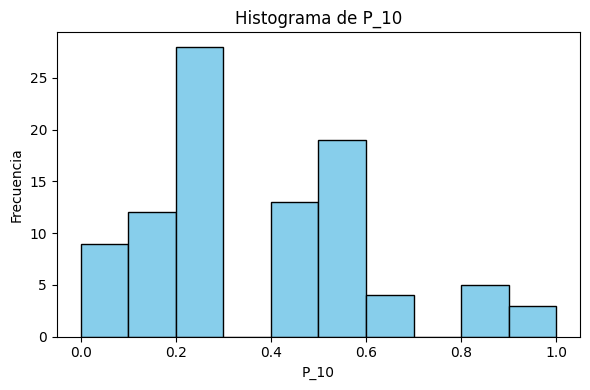

P_10 - media: 0.358, mediana: 0.300, desviación estándar: 0.246


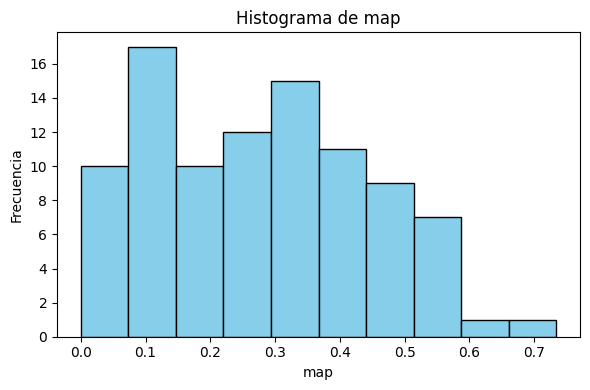

map - media: 0.284, mediana: 0.284, desviación estándar: 0.169


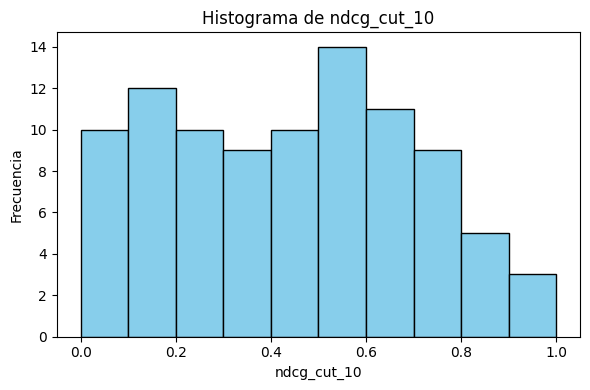

ndcg_cut_10 - media: 0.435, mediana: 0.444, desviación estándar: 0.265


In [6]:
import numpy as np

metrics = ['P_10', 'map', 'ndcg_cut_10']
for metric in metrics:
    values = indv_exp[indv_exp['measure'] == metric]['value'].astype(float).values
    plt.figure(figsize=(6, 4))
    plt.hist(values, bins=10, color='skyblue', edgecolor='black')
    plt.title(f'Histograma de {metric}')
    plt.xlabel(metric)
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.savefig(f"hist_{metric}.png")
    plt.show()
    print(f"{metric} - media: {np.mean(values):.3f}, mediana: {np.median(values):.3f}, desviación estándar: {np.std(values):.3f}")